In [1]:
###############################
# import packages
###############################
% config Completer.use_jedi = False
import os
import matplotlib.pyplot as plt
from keras_flops import get_flops
% matplotlib inline
#import sys
#print(sys.path)

2022-06-15 12:25:27.089318: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
###############################
# enable GPUs
###############################
from utils import enable_gpu

# default 0 to get the first gpu, if you have more than one you can make them into one liste like this "0,2" to indicate the gpu : 0 and gpu : 2. 
gpu_list = '0'
if gpu_list is not None:
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu_list
    print(gpu_list)
    gpu_code = enable_gpu(list(range(len(gpu_list.split(',')))))
    if gpu_code < 1:
        print('[ENABLE GPU ERROR]')
        os.environ['CUDA_VISIBLE_DEVICES'] = ""
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

0
gpus divices [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[0]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
gpu set memory OK for gpu PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs , 1 Logical GPU


2022-06-15 12:25:37.881772: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-15 12:25:37.882905: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-15 12:25:40.943122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-06-15 12:25:40.943171: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-15 12:25:40.945530: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-15 12:25:40.945607: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

0
gpus divices [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[0]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
gpu set memory OK for gpu PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs , 1 Logical GPU


In [4]:
#compute FLOPS of models

In [ ]:
###############################
# load model
###############################
from tensorflow.keras.models import load_model

#prepare model
metric_threshold = 0.5
Model_path = "./model/wildfire_Unet_MobileNetv3_model_40m.h5"
model = load_model(Model_path)

###############################
# Compute FLOPS of models
###############################
flops_unet = get_flops(model, 1)
print(f"FLOPS unet mnv3: {flops_unet / 10 ** 9:.03} G")
###############################
# visualize  the model 
###############################
import visualkeras

visualkeras.layered_view(model, legend=True, to_file='output.png')

In [6]:
###############################
# define path to images
###############################
from utils import is_path

#define path to images
subset = "test"
path_valid_file = is_path("data/image_distribution/{}.txt".format(subset))
path_valid_image_folder_FC = is_path("data/false_color/")
path_valid_image_folder_RGB = is_path("data/RGB/")
path_valid_gtmask_folder = is_path("data/masks/")


In [7]:
###############################
# Get all images paths
###############################
from utils import get_files_list

validation_path_image_list_FC = get_files_list(path_valid_file, path_valid_image_folder_FC, extension='.tif')
print(len(validation_path_image_list_FC))
print(validation_path_image_list_FC[:5])

3
['data/false_color/_Sentinel-2 L1C from 2017-12-08_SantaBarbara_BANDS-S2-L1C_0_5.tif', 'data/false_color/_Sentinel-2 L1C from 2018-08-16_Mendocino_BANDS-S2-L1C_0_5.tif', 'data/false_color/_Sentinel-2 L1C from 2019-11-12_PortMacquarie2_BANDS-S2-L1C_0_77.tif']


In [8]:
def transform_predected_mask(pred_mask, threshhold=0.5):
    pred_mask[pred_mask >= threshhold] = 1.0
    pred_mask[pred_mask < threshhold] = 0.0
    return pred_mask.astype(np.uint8)


def predict(model, image, threshhold=0.5):
    # this predict method wotk only for binary classes (sigmoid activation)
    pred_mask = model.predict(image)
    return transform_predected_mask(pred_mask, threshhold=threshhold)


def create_images_from_bands(a, channels_list=None):
    """
    This function can help you to extract some bands from the multispectral data
    :param a: array [D1,D2,D3] dimension
    :param channels_list: list of channel to extract from D3
    :return: array [D1,D2,|channels_list|]
    """
    if channels_list is None:
        channels_list = [3, 2, 1]
    c = np.zeros((a.shape[0], a.shape[1], len(channels_list)), dtype=a.dtype)
    for i, j in enumerate(channels_list):
        c[:, :, i] = a[:, :, j]

    return c


def intersection_over_union(actual, pred):
    intersection = np.logical_and(actual, pred).sum()
    union = np.logical_or(actual, pred).sum()
    return intersection / union


def Pierre_Markuse(false_color):
    PMmask = np.where(((false_color[:, :, 0] + false_color[:, :, 1]) > 1), 1, 0)
    return PMmask


def max_normalization(image):
    image = image / image.max()
    return image


In [9]:
def display(display_list, title_list=None):
    plt.figure(figsize=(60, 30))
    if title_list is None:
        title = ['Input Image', 'GT Mask', 'Predicted Mask']
    else:
        title = title_list
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i], c='BLACK')
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()


def get_confusion_matrix_intersection_mats(groundtruth, predicted):
    """
    Returns dict of 4 boolean numpy arrays with True at TP, FP, FN, TN
    """
    confusion_matrix_arrs = {}
    groundtruth_inverse = np.logical_not(groundtruth)
    predicted_inverse = np.logical_not(predicted)

    confusion_matrix_arrs['tp'] = np.logical_and(groundtruth, predicted)
    confusion_matrix_arrs['tn'] = np.logical_and(groundtruth_inverse, predicted_inverse)
    confusion_matrix_arrs['fp'] = np.logical_and(groundtruth_inverse, predicted)
    confusion_matrix_arrs['fn'] = np.logical_and(groundtruth, predicted_inverse)

    return confusion_matrix_arrs


def get_confusion_matrix_overlaid_mask(image, groundtruth, predicted, colors):
    """
    Returns overlay the 'image' with a color mask where TP, FP, FN, TN are
    each a color given by the 'colors' dictionary
    """
    masks = get_confusion_matrix_intersection_mats(groundtruth, predicted)
    color_mask = np.zeros_like(image)
    for label, mask in masks.items():
        color = colors[label]
        mask_rgb = np.zeros_like(image)
        mask_rgb[mask != 0] = color
        color_mask += mask_rgb
    return color_mask





[INFO] counter   :   0 
[INFO] fila name :   data/false_color/_Sentinel-2 L1C from 2017-12-08_SantaBarbara_BANDS-S2-L1C_0_5.tif 


2022-06-15 12:27:27.850171: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-15 12:27:57.407591: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-06-15 12:29:04.705749: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


##################################################
[INFO] type          :  uint8
[INFO] shape         :  (256, 256, 3)
[INFO] max           :  117
[INFO] min           :  7
[INFO] moy           :  30.924306233723957
##################################################
##################################################
[INFO] type          :  uint8
[INFO] shape         :  (256, 256, 3)
[INFO] max           :  255
[INFO] min           :  3
[INFO] moy           :  34.55749003092448
##################################################
##################################################
[INFO] type          :  uint8
[INFO] shape         :  (256, 256)
[INFO] max           :  1
[INFO] min           :  0
[INFO] moy           :  0.007965087890625
[INFO] non zeros : 522
##################################################
[INFO] : IoU score  :   0.966542750929368 


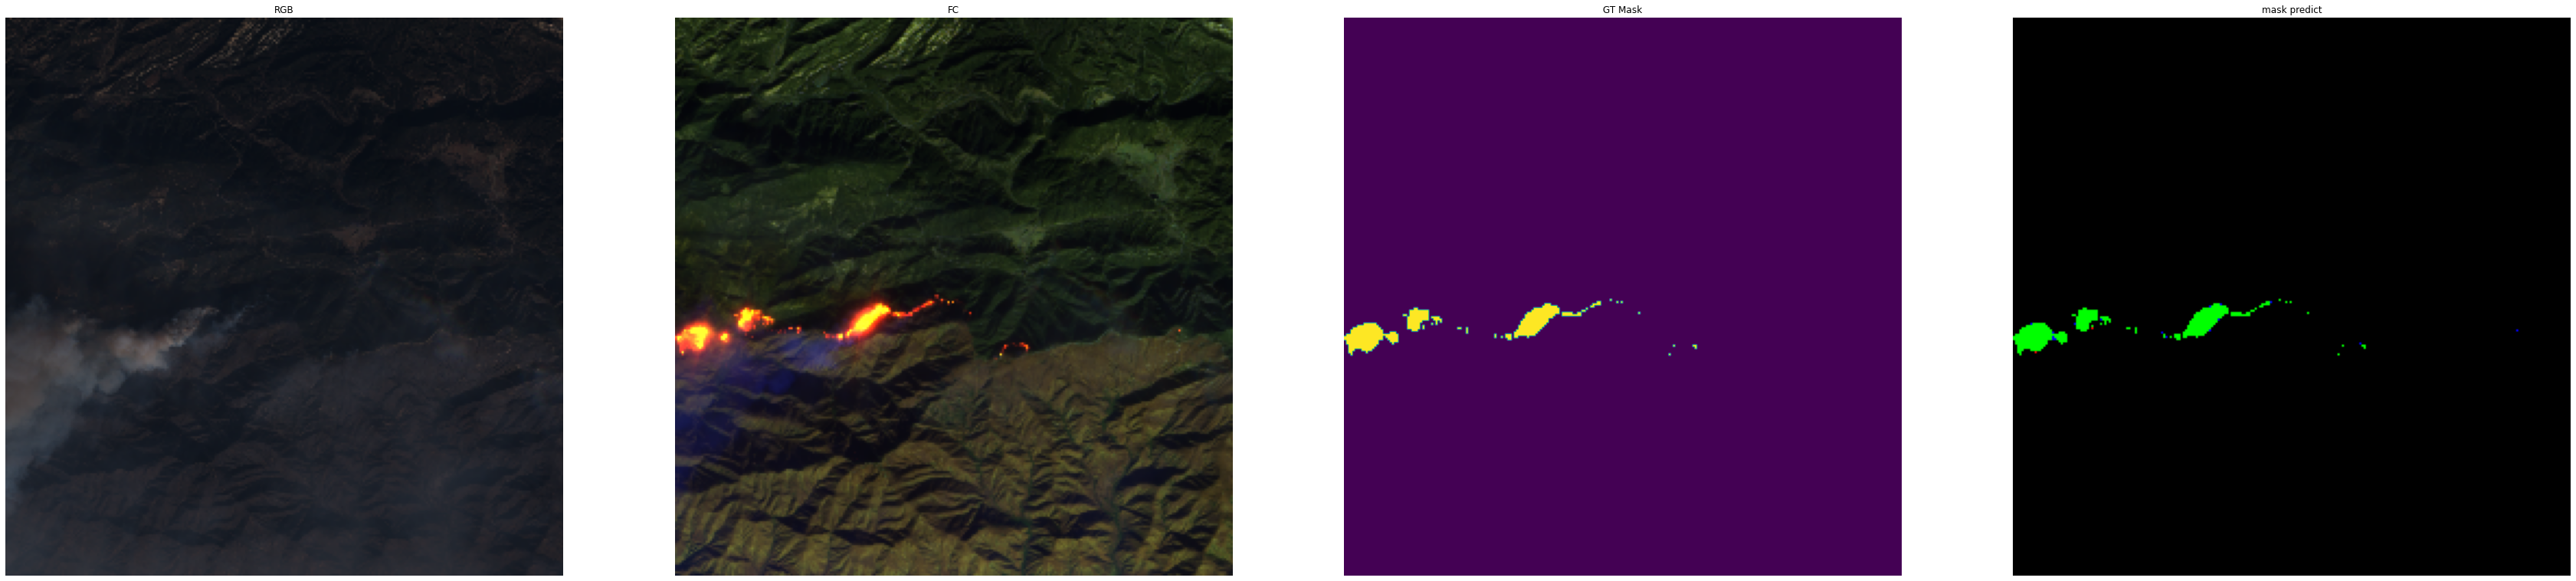

[INFO] counter   :   1 
[INFO] fila name :   data/false_color/_Sentinel-2 L1C from 2018-08-16_Mendocino_BANDS-S2-L1C_0_5.tif 
##################################################
[INFO] type          :  uint8
[INFO] shape         :  (256, 256, 3)
[INFO] max           :  75
[INFO] min           :  5
[INFO] moy           :  29.511459350585938
##################################################
##################################################
[INFO] type          :  uint8
[INFO] shape         :  (256, 256, 3)
[INFO] max           :  255
[INFO] min           :  0
[INFO] moy           :  28.661417643229168
##################################################
##################################################
[INFO] type          :  uint8
[INFO] shape         :  (256, 256)
[INFO] max           :  1
[INFO] min           :  0
[INFO] moy           :  0.0099334716796875
[INFO] non zeros : 651
##################################################
[INFO] : IoU score  :   0.9671150971599403 


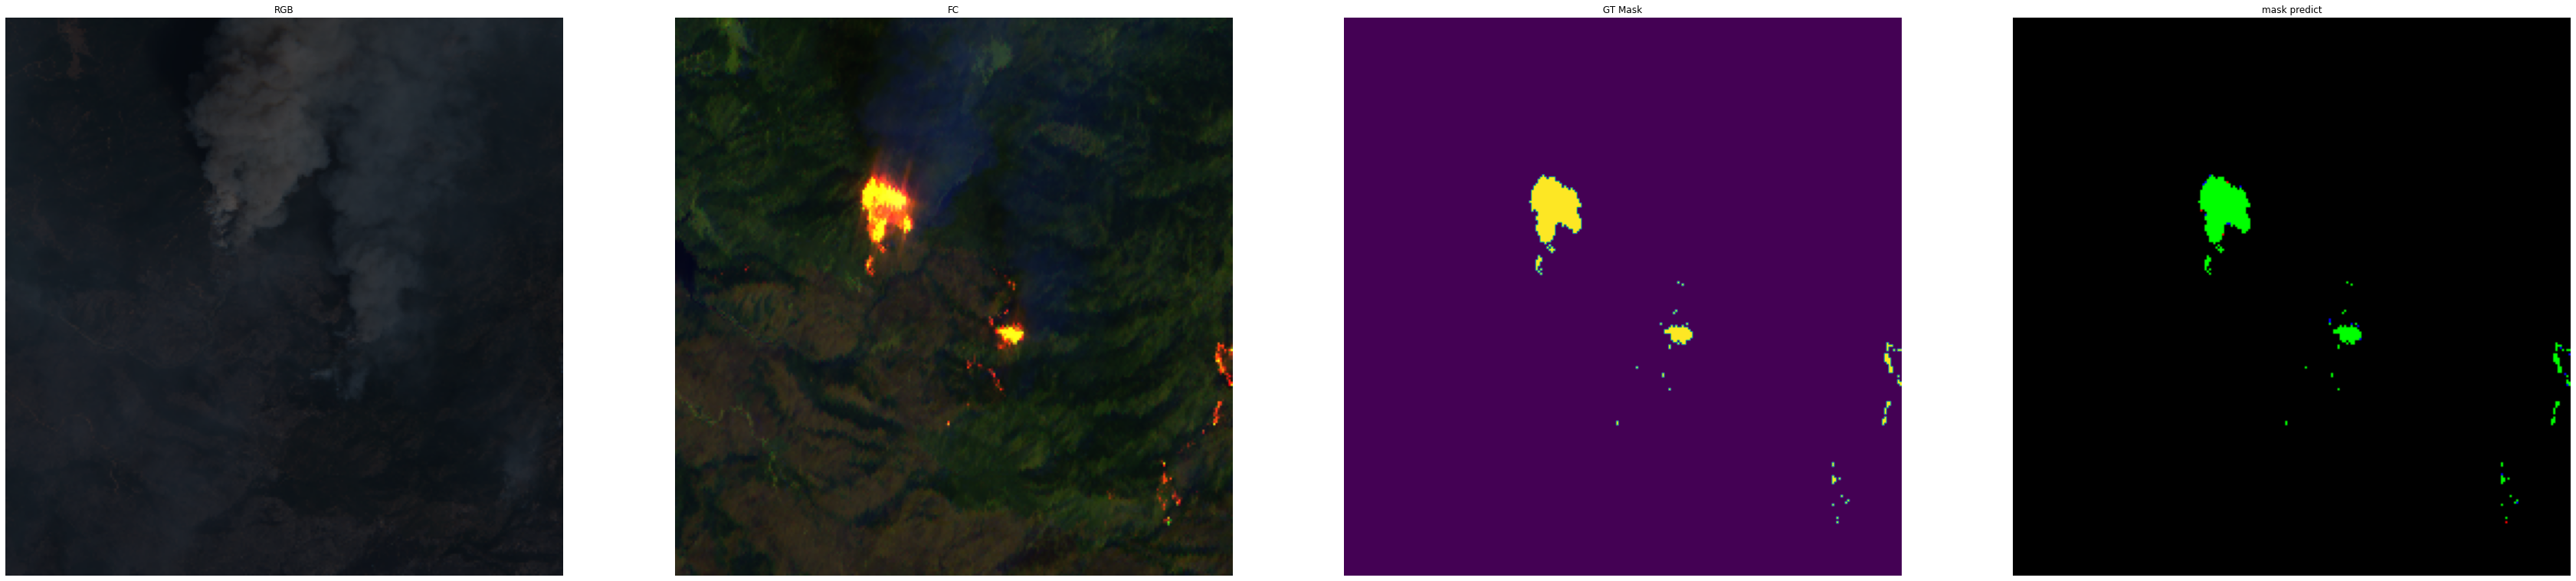

[INFO] counter   :   2 
[INFO] fila name :   data/false_color/_Sentinel-2 L1C from 2019-11-12_PortMacquarie2_BANDS-S2-L1C_0_77.tif 
##################################################
[INFO] type          :  uint8
[INFO] shape         :  (256, 256, 3)
[INFO] max           :  70
[INFO] min           :  8
[INFO] moy           :  36.436309814453125
##################################################
##################################################
[INFO] type          :  uint8
[INFO] shape         :  (256, 256, 3)
[INFO] max           :  255
[INFO] min           :  8
[INFO] moy           :  42.196685791015625
##################################################
##################################################
[INFO] type          :  uint8
[INFO] shape         :  (256, 256)
[INFO] max           :  1
[INFO] min           :  0
[INFO] moy           :  0.0046234130859375
[INFO] non zeros : 303
##################################################
[INFO] : IoU score  :   0.9233226837060703 


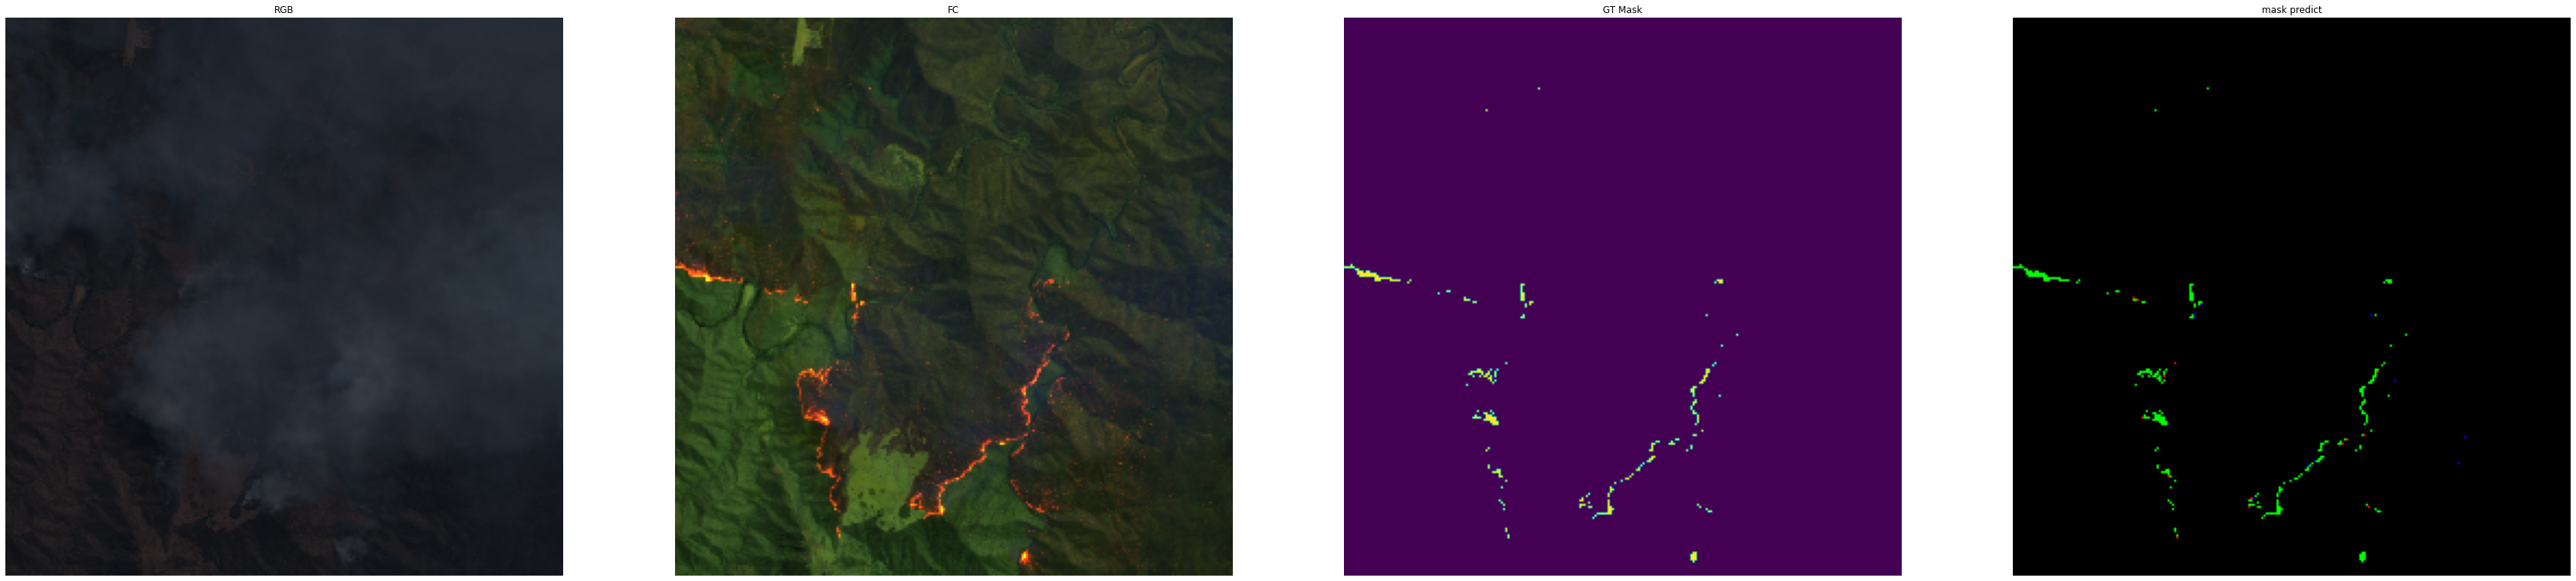

In [10]:
import numpy as np
from utils import data_read, ndarray_info

confusion_matrix_colors = {
    'tp': (0, 255, 0),  #green
    'fp': (0, 0, 255),  #BLUE
    'fn': (255, 0, 0),  #RED
    'tn': (0, 0, 0)  #black
}

for counter, image_path_fc in enumerate(validation_path_image_list_FC):
    ###############################
    # infos about loop
    ###############################
    print("[INFO] counter   :   {} ".format(counter))
    print("[INFO] fila name :   {} ".format(image_path_fc))
    ###############################
    # create paths
    ###############################
    gtmask_path = image_path_fc.replace(path_valid_image_folder_FC, path_valid_gtmask_folder)
    image_path_RGB = image_path_fc.replace(path_valid_image_folder_FC, path_valid_image_folder_RGB)

    ###############################
    # read data
    ###############################
    image_fc = data_read(image_path_fc)
    image_RGB = data_read(image_path_RGB)
    gtmask = data_read(gtmask_path)

    #validation_mask_PM = get_confusion_matrix_overlaid_mask(image_fc, gtmask, PM_mask, confusion_matrix_colors)
    #validation_mask_nano = get_confusion_matrix_overlaid_mask(image_fc,gtmask, nano_mask, confusion_matrix_colors)

    ###############################
    # predict from model
    ###############################
    # transform data
    image_fc = np.expand_dims(image_fc, axis=0)
    #predict data
    pred_mask = predict(model, image_fc, threshhold=metric_threshold)
    image_fc = np.squeeze(image_fc, axis=0)
    pred_mask = np.squeeze(pred_mask, axis=(0, -1))

    ###############################
    #  data info
    ###############################
    ndarray_info(image_RGB)
    ndarray_info(image_fc)
    ndarray_info(gtmask, count_non_zero=True)

    ###############################
    # calculate scores
    ###############################
    prediction_score = intersection_over_union(gtmask, pred_mask)
    ###############################
    # print scores
    ###############################
    print('[INFO] : IoU score  :   {} '.format(prediction_score))

    ###############################
    # display images
    ###############################
    validation_mask_pred = get_confusion_matrix_overlaid_mask(image_fc, gtmask, pred_mask, confusion_matrix_colors)
    display([image_RGB, image_fc, gtmask, validation_mask_pred], title_list=['RGB', 'FC', 'GT Mask', 'mask predict'])

